# Loan granting
## Goal :
Another area where data science and machine learning play a huge role is in choosing if
granting a loan. This is a particularly hot field as many start-ups feel that bank loan models can
be improved. Therefore, there is space to come up with better loan strategies that can benefit
both the lender and the borrower.
In this challenge, you will have access to loan data from a bank and will have to improve their
model.

## Challenge Description :

We have access to a specific bank loan data. We have data about all loans asked to the bank,
whether the bank decided to grant it and, finally, whether the borrower managed to repay it. We
also have info about the borrower at the moment she is asking for the loan.
You have to come up with a better strategy to grant loans. Specifically you should:
Build a model which is better than the bank model. For simplicity, assume that:
If you grant the loan and the it doesn't get repaid, you lose 1
If you grant the loan and the it does get repaid, you gain 1
If you don't grant the loan, you gain 0
Using the rules above, compare bank profitability vs your model profitability
Describe the impact of the most important variables on the prediction. Also, focus on the
variable "is_employed", which describes whether the borrower is employed when she
asks for the loan. How does this variable impact the model? Explain why
Are there any other variables, not in the data provided, that you'd have liked to include in
the model?

In [40]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_auc_score,roc_curve

In [2]:
loan = pd.read_csv('loan_table.csv')
borrower = pd.read_csv('borrower_table.csv')

In [3]:
loan.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid
0,19454,investment,2012-03-15,0,NaN
1,496811,investment,2012-01-17,0,NaN
2,929493,other,2012-02-09,0,NaN
3,580653,other,2012-06-27,1,1.0
4,172419,business,2012-05-21,1,0.0


In [4]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   loan_id       101100 non-null  int64  
 1   loan_purpose  101100 non-null  object 
 2   date          101100 non-null  object 
 3   loan_granted  101100 non-null  int64  
 4   loan_repaid   47654 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 3.9+ MB


In [5]:
loan.describe()

,loan_id,loan_granted,loan_repaid
count,101100.000000,101100.000000,47654.000000
mean,499666.826726,0.471355,0.644353
std,288662.006929,0.499181,0.478714
min,30.000000,0.000000,0.000000
25%,250333.750000,0.000000,0.000000
50%,499885.000000,0.000000,1.000000
75%,749706.250000,1.000000,1.000000
max,999987.000000,1.000000,1.000000


In [10]:
borrower.head()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,289774,1,NaN,NaN,8000,0.49,3285,1073,0,0,47,3
1,482590,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1
2,135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8
3,207797,0,1.0,0.0,1200,0.82,358,3388,0,0,24,1
4,828078,0,0.0,0.0,6900,0.80,2138,4282,1,18100,36,1


In [11]:
borrower.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 12 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   loan_id                                          101100 non-null  int64  
 1   is_first_loan                                    101100 non-null  int64  
 2   fully_repaid_previous_loans                      46153 non-null   float64
 3   currently_repaying_other_loans                   46153 non-null   float64
 4   total_credit_card_limit                          101100 non-null  int64  
 5   avg_percentage_credit_card_limit_used_last_year  94128 non-null   float64
 6   saving_amount                                    101100 non-null  int64  
 7   checking_amount                                  101100 non-null  int64  
 8   is_employed                                      101100 non-null  int64  
 9   yearly_salary  

In [12]:
borrower.describe()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
count,101100.000000,101100.000000,46153.000000,46153.000000,101100.000000,94128.000000,101100.000000,101100.000000,101100.000000,101100.000000,101100.000000,101100.000000
mean,499666.826726,0.543492,0.899291,0.364332,4112.743818,0.724140,1799.617616,3177.150821,0.658675,21020.727992,41.491632,3.864748
std,288662.006929,0.498107,0.300946,0.481247,2129.121462,0.186483,1400.545141,2044.448155,0.474157,18937.581415,12.825570,2.635491
min,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000
25%,250333.750000,0.000000,1.000000,0.000000,2700.000000,0.600000,834.000000,1706.000000,0.000000,0.000000,32.000000,2.000000
50%,499885.000000,1.000000,1.000000,0.000000,4100.000000,0.730000,1339.000000,2673.000000,1.000000,21500.000000,41.000000,3.000000
75%,749706.250000,1.000000,1.000000,1.000000,5500.000000,0.860000,2409.000000,4241.000000,1.000000,35300.000000,50.000000,6.000000
max,999987.000000,1.000000,1.000000,1.000000,13500.000000,1.090000,10641.000000,13906.000000,1.000000,97200.000000,79.000000,8.000000


In [13]:
data = pd.merge(left=loan, right=borrower, on='loan_id')

In [14]:
data = data[data['loan_granted'] == 1]

In [15]:
data.isnull().sum()

loan_id                                                0
loan_purpose                                           0
date                                                   0
loan_granted                                           0
loan_repaid                                            0
is_first_loan                                          0
fully_repaid_previous_loans                        25789
currently_repaying_other_loans                     25789
total_credit_card_limit                                0
avg_percentage_credit_card_limit_used_last_year      903
saving_amount                                          0
checking_amount                                        0
is_employed                                            0
yearly_salary                                          0
age                                                    0
dependent_number                                       0
dtype: int64

In [16]:
data['date']=pd.to_datetime(data['date'])
data['month']=data['date'].dt.month
data['week']=data['date'].dt.isocalendar().week
data['dayofweek']=data['date'].dt.dayofweek
data=data.drop(columns=['loan_id','date','loan_granted'])

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47654 entries, 3 to 101098
Data columns (total 16 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   loan_purpose                                     47654 non-null  object 
 1   loan_repaid                                      47654 non-null  float64
 2   is_first_loan                                    47654 non-null  int64  
 3   fully_repaid_previous_loans                      21865 non-null  float64
 4   currently_repaying_other_loans                   21865 non-null  float64
 5   total_credit_card_limit                          47654 non-null  int64  
 6   avg_percentage_credit_card_limit_used_last_year  46751 non-null  float64
 7   saving_amount                                    47654 non-null  int64  
 8   checking_amount                                  47654 non-null  int64  
 9   is_employed                     

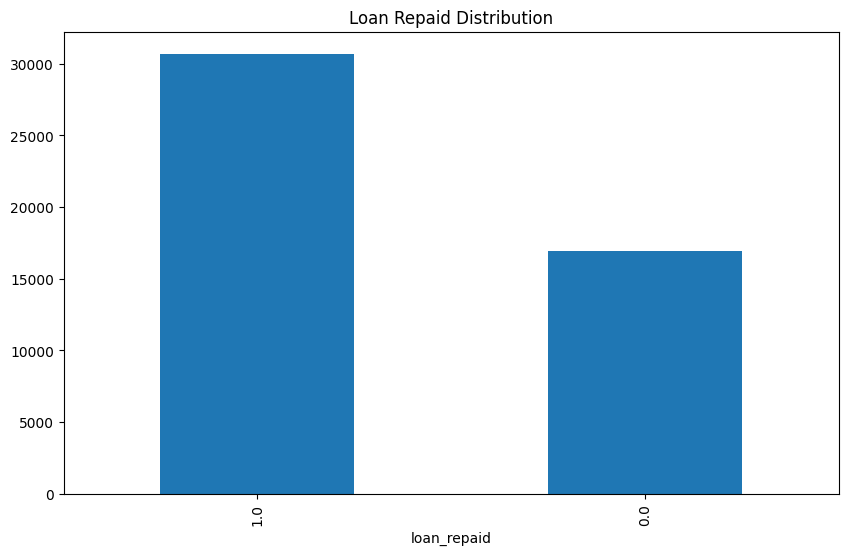

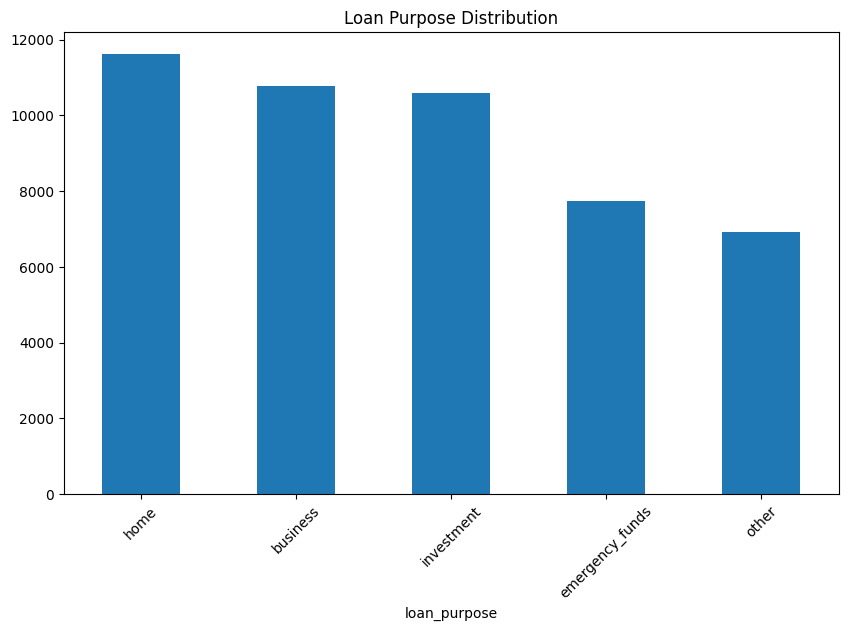

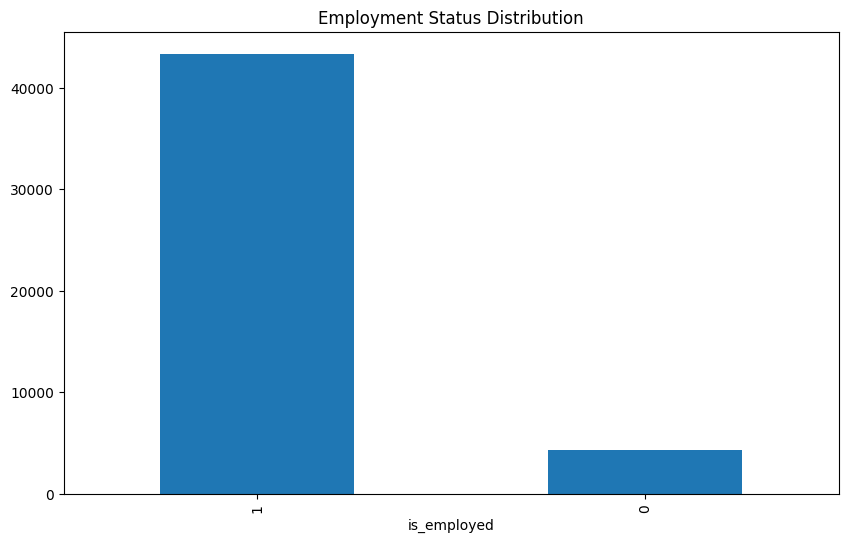

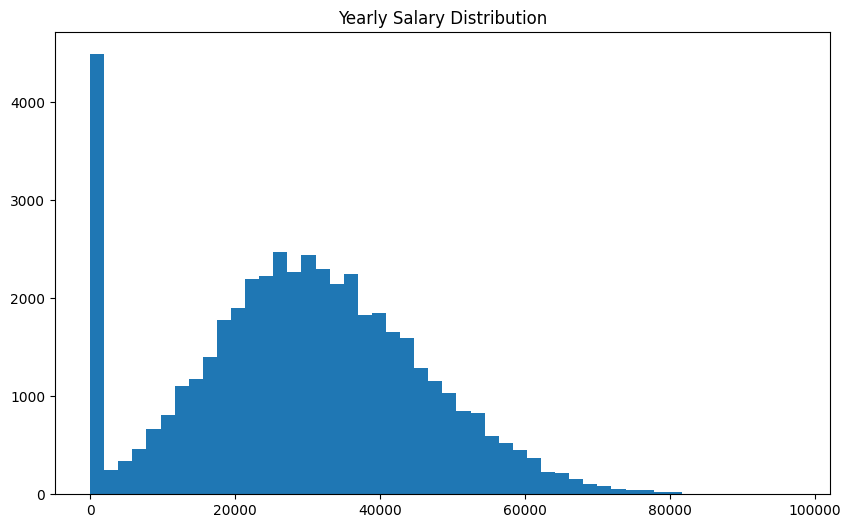

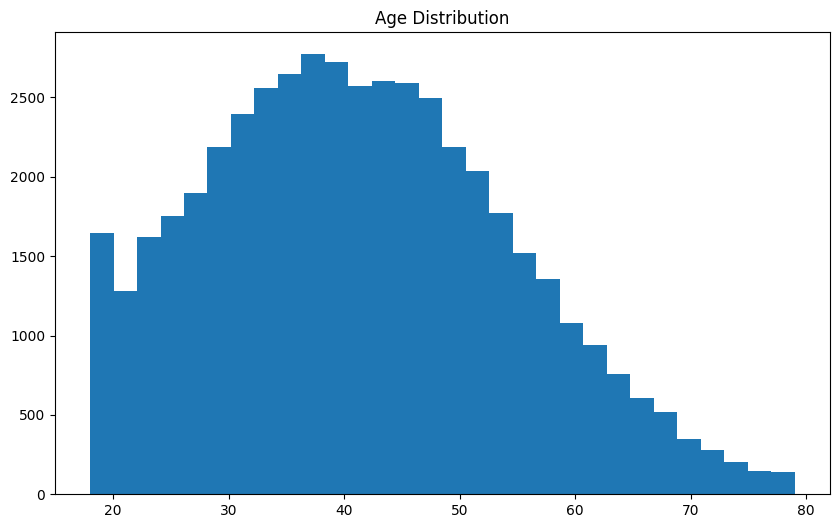

In [21]:
data['loan_repaid'].value_counts().plot(kind='bar', figsize=(10,6))
plt.title('Loan Repaid Distribution')
plt.show()

data['loan_purpose'].value_counts().plot(kind='bar', figsize=(10,6))
plt.title('Loan Purpose Distribution')
plt.xticks(rotation=45)
plt.show()

data['is_employed'].value_counts().plot(kind='bar', figsize=(10,6))
plt.title('Employment Status Distribution')
plt.show()

plt.figure(figsize=(10,6))
plt.hist(data['yearly_salary'], bins=50)
plt.title('Yearly Salary Distribution')
plt.show()

plt.figure(figsize=(10,6))
plt.hist(data['age'], bins=30)
plt.title('Age Distribution')
plt.show()

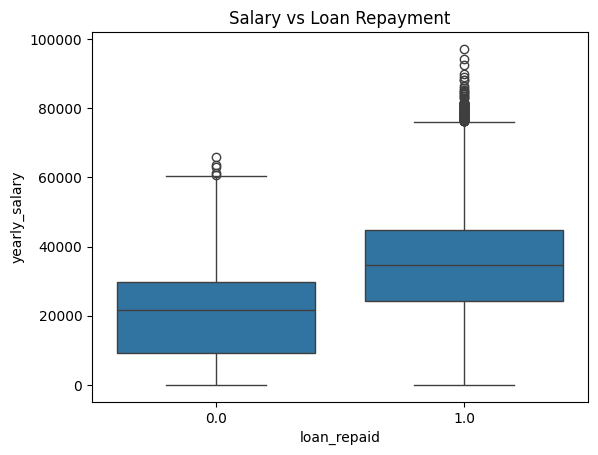

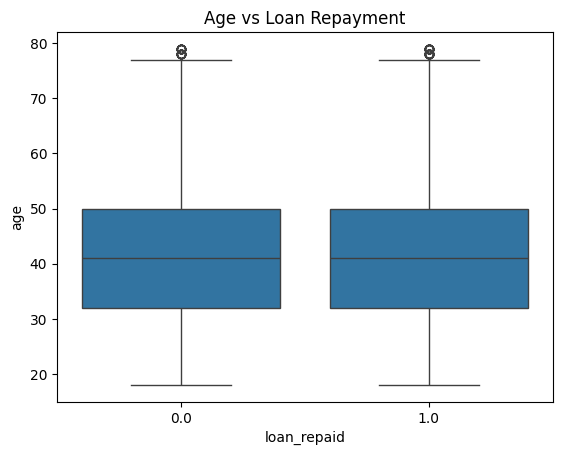

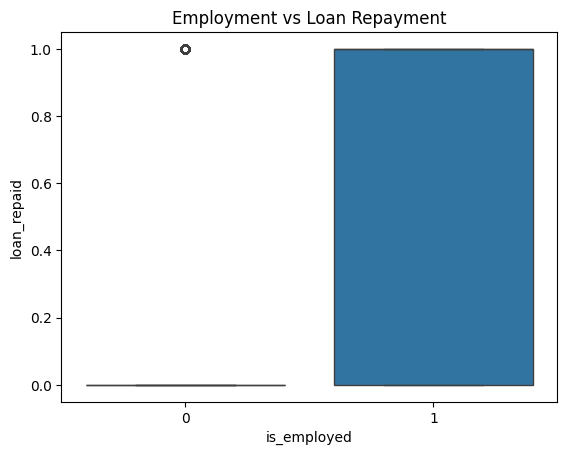

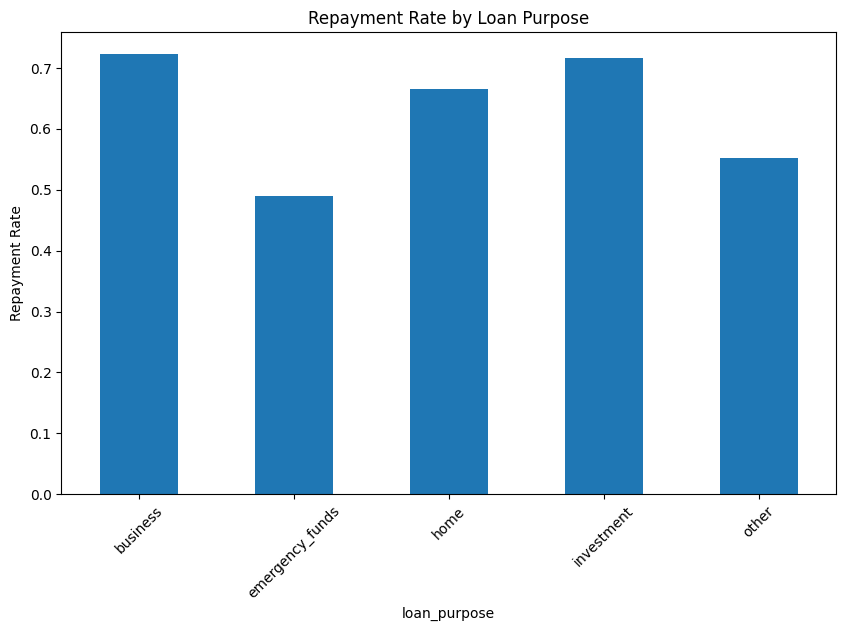

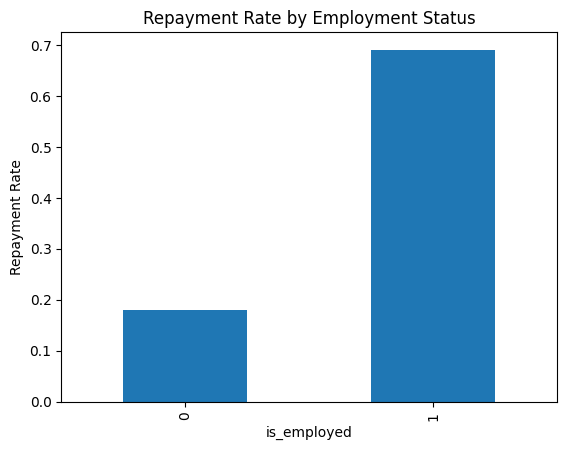

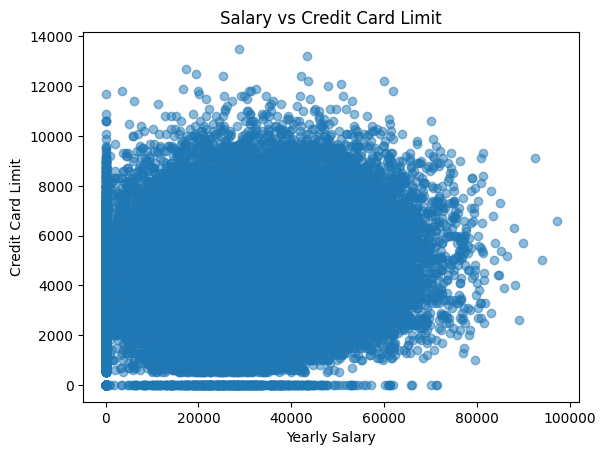

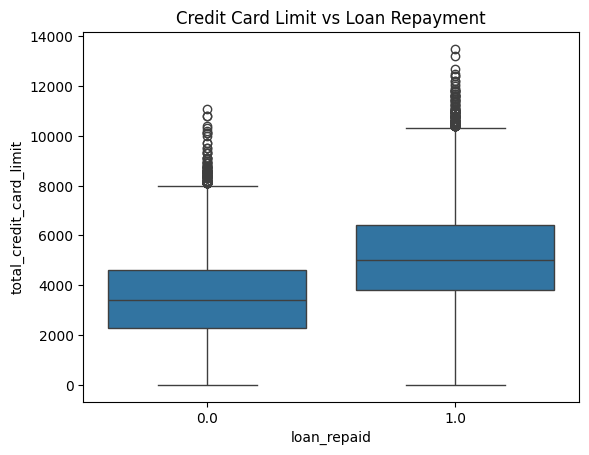

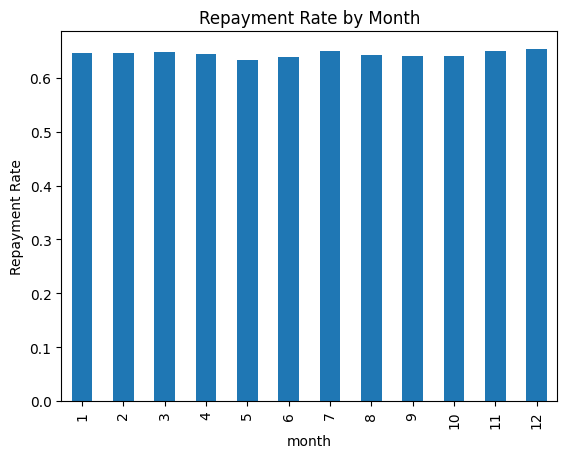

In [23]:
sns.boxplot(x='loan_repaid',y='yearly_salary',data=data)
plt.title('Salary vs Loan Repayment')
plt.show()

sns.boxplot(x='loan_repaid',y='age',data=data)
plt.title('Age vs Loan Repayment')
plt.show()

sns.boxplot(x='is_employed',y='loan_repaid',data=data)
plt.title('Employment vs Loan Repayment')
plt.show()

data.groupby('loan_purpose')['loan_repaid'].mean().plot(kind='bar',figsize=(10,6))
plt.title('Repayment Rate by Loan Purpose')
plt.xticks(rotation=45)
plt.ylabel('Repayment Rate')
plt.show()

data.groupby('is_employed')['loan_repaid'].mean().plot(kind='bar')
plt.title('Repayment Rate by Employment Status')
plt.ylabel('Repayment Rate')
plt.show()

plt.scatter(data['yearly_salary'],data['total_credit_card_limit'],alpha=0.5)
plt.title('Salary vs Credit Card Limit')
plt.xlabel('Yearly Salary')
plt.ylabel('Credit Card Limit')
plt.show()

sns.boxplot(x='loan_repaid',y='total_credit_card_limit',data=data)
plt.title('Credit Card Limit vs Loan Repayment')
plt.show()

data.groupby('month')['loan_repaid'].mean().plot(kind='bar')
plt.title('Repayment Rate by Month')
plt.ylabel('Repayment Rate')
plt.show()

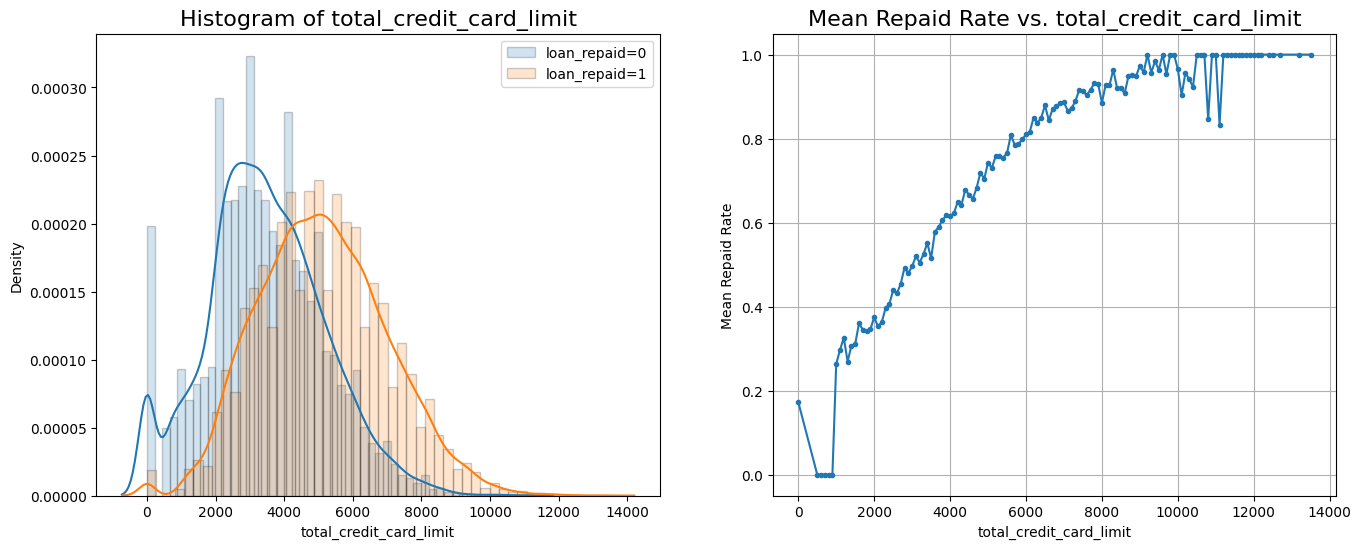

In [24]:
grouped=data[['total_credit_card_limit','loan_repaid']].groupby('total_credit_card_limit')
mean=grouped.mean().reset_index()
hist_kws={'histtype':'bar','edgecolor':'black','alpha':0.2}
import warnings
warnings.filterwarnings('ignore')
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(16,6))
sns.distplot(data[data['loan_repaid']==0]['total_credit_card_limit'],label='loan_repaid=0',ax=ax[0],hist_kws=hist_kws)
sns.distplot(data[data['loan_repaid']==1]['total_credit_card_limit'],label='loan_repaid=1',ax=ax[0],hist_kws=hist_kws)
ax[0].set_title('Histogram of total_credit_card_limit',fontsize=16)
ax[0].legend()
ax[1].plot(mean['total_credit_card_limit'],mean['loan_repaid'],'.-')
ax[1].set_title('Mean Repaid Rate vs. total_credit_card_limit',fontsize=16)
ax[1].set_xlabel('total_credit_card_limit')
ax[1].set_ylabel('Mean Repaid Rate')
ax[1].grid(True)
plt.show()

In [26]:
for col in ['yearly_salary','age','total_credit_card_limit','saving_amount']:
    corr,p=pointbiserialr(data['loan_repaid'],data[col])
    print(f"{col}: {corr:.3f} (p={p:.3f})")

yearly_salary: 0.427 (p=0.000)
age: 0.001 (p=0.836)
total_credit_card_limit: 0.402 (p=0.000)
saving_amount: 0.494 (p=0.000)


In [28]:
crosstab=pd.crosstab(data['is_employed'],data['loan_repaid'])
chi2,p_value,dof,expected=chi2_contingency(crosstab)
print(f"Employment: Chi2={chi2:.4f}, p-value={p_value:.4f}")
crosstab=pd.crosstab(data['loan_purpose'],data['loan_repaid'])
chi2,p_value,dof,expected=chi2_contingency(crosstab)
print(f"Loan Purpose: Chi2={chi2:.4f}, p-value={p_value:.4f}")

Employment: Chi2=4452.5817, p-value=0.0000
Loan Purpose: Chi2=1618.1761, p-value=0.0000


People with more savings tend to repay their loans much better and income also plays a big role because those with higher salaries show stronger repayment patterns while people who have higher credit card limits also perform well in repayment. Age does not really affect repayment at all. Employment status matters a lot since being employed makes repayment much more likely and the purpose of the loan also influences how reliable repayment will be. So if you want to build a loan approval model the features that matter most are savings income credit limits employment and loan purpose while age can safely be ignored.

In [29]:
data = data.fillna({'fully_repaid_previous_loans': 0, 'currently_repaying_other_loans': 0})

In [30]:
data['avg_percentage_credit_card_limit_used_last_year'].interpolate(method='linear', inplace=True)

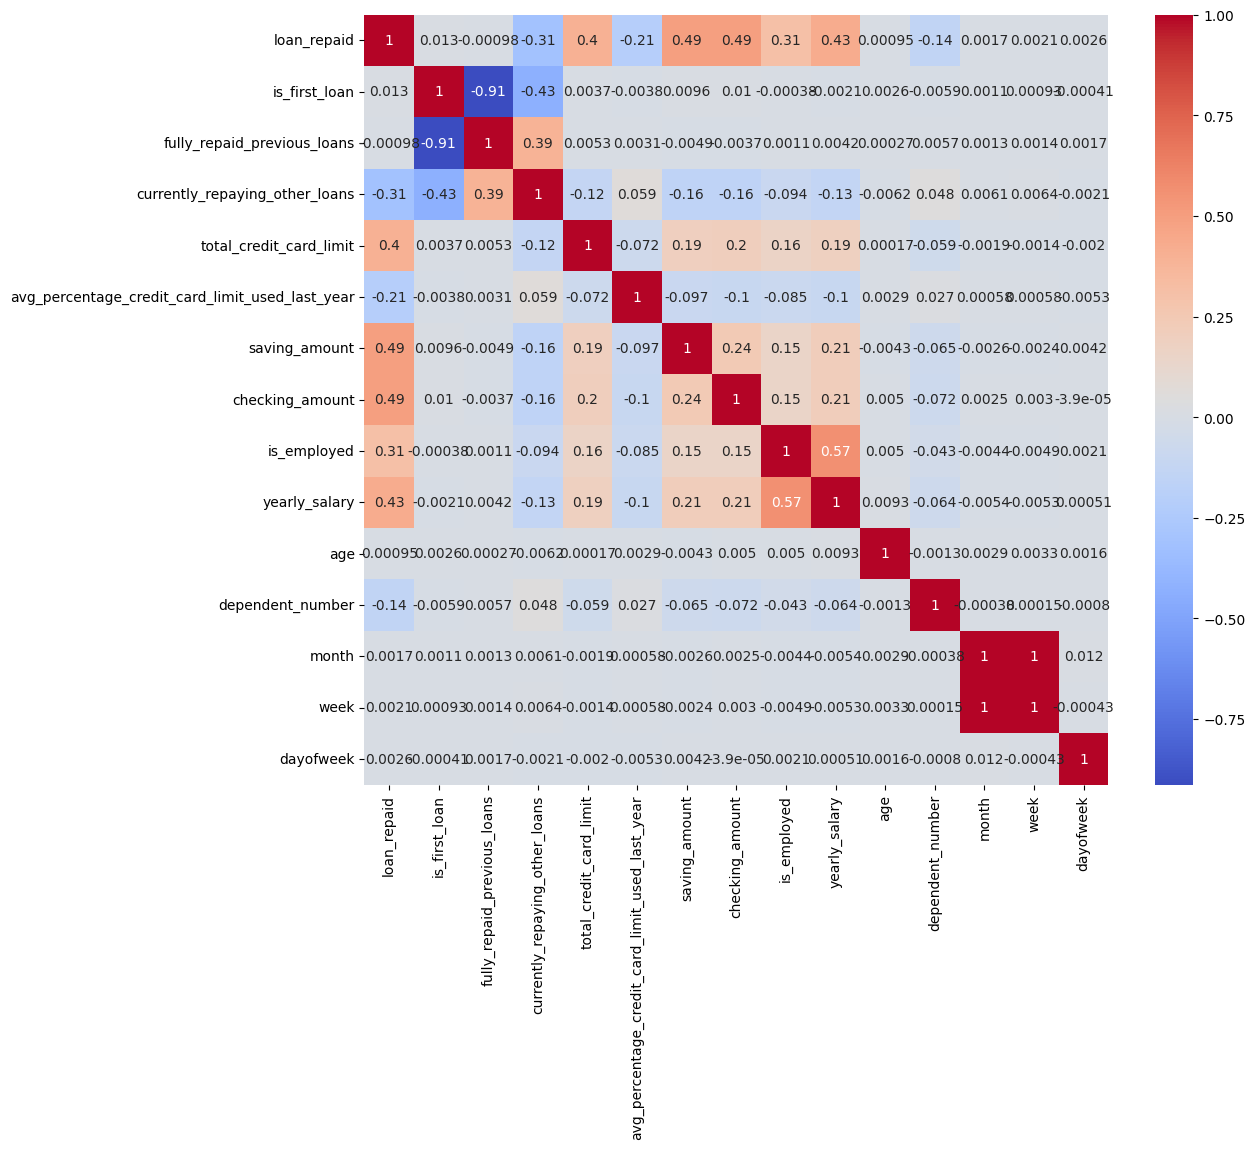

In [32]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(data.select_dtypes(include='number').corr(), ax=ax, annot=True, cmap='coolwarm')
plt.show()

Being employed is the biggest factor in whether someone repays their loan because it shows the strongest correlation and having more savings and a healthy checking account also helps a lot since people with higher balances are more reliable. Income matters too because higher salaries increase repayment likelihood and having more credit available is another positive sign. On the other hand juggling other loans makes repayment harder and using too much credit is risky. Age does not really affect repayment and timing features like month week or day of the week barely matter. There are also some natural interactions like employed people usually having higher salaries and savings and checking balances being moderately linked. So for a model the key features to focus on are employment savings checking income and credit limits while other loans age and temporal details can be ignored.


In [33]:
data.head()

,loan_purpose,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number,month,week,dayofweek
3,other,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4,6,26,2
4,business,0.0,1,0.0,0.0,2900,0.76,1050,3695,1,34800,31,4,5,21,0
6,business,1.0,0,1.0,0.0,7800,0.30,4206,4368,1,51100,51,2,3,11,2
7,emergency_funds,0.0,0,0.0,1.0,4300,1.02,886,1597,1,15000,59,2,8,35,4
8,investment,1.0,0,1.0,0.0,3900,0.65,1837,3795,1,12000,24,1,5,21,4


In [34]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47654 entries, 3 to 101098
Data columns (total 16 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   loan_purpose                                     47654 non-null  object 
 1   loan_repaid                                      47654 non-null  float64
 2   is_first_loan                                    47654 non-null  int64  
 3   fully_repaid_previous_loans                      47654 non-null  float64
 4   currently_repaying_other_loans                   47654 non-null  float64
 5   total_credit_card_limit                          47654 non-null  int64  
 6   avg_percentage_credit_card_limit_used_last_year  47654 non-null  float64
 7   saving_amount                                    47654 non-null  int64  
 8   checking_amount                                  47654 non-null  int64  
 9   is_employed                     

In [37]:
encoder = LabelEncoder()
data['loan_purpose'] = encoder.fit_transform(data['loan_purpose'])

In [39]:
X = data.drop('loan_repaid', axis=1)
y = data['loan_repaid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [43]:
model=XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    min_child_weight=1,
    reg_alpha=0,
    reg_lambda=1,
    scale_pos_weight=1
)

In [44]:
model.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [45]:
y_pred=model.predict(X_test)

In [46]:
y_pred_proba=model.predict_proba(X_test)[:,1]

In [47]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.88      0.92      0.90      4237
         1.0       0.95      0.93      0.94      7677

    accuracy                           0.92     11914
   macro avg       0.91      0.92      0.92     11914
weighted avg       0.92      0.92      0.92     11914



In [48]:
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[3879  358]
 [ 552 7125]]


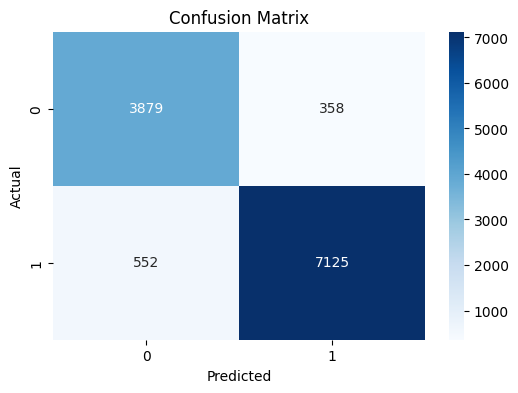

In [49]:
plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [50]:
roc_auc=roc_auc_score(y_test,y_pred_proba)
print(f"\nROC AUC Score: {roc_auc:.4f}")


ROC AUC Score: 0.9771


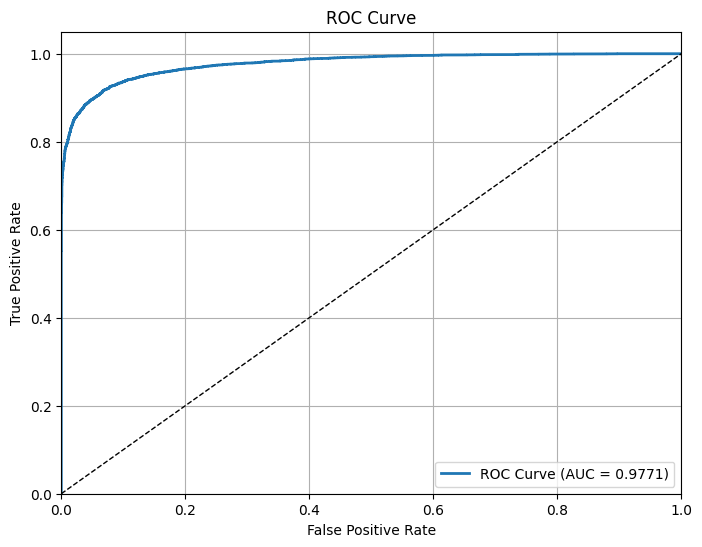

In [51]:
fpr,tpr,thresholds=roc_curve(y_test,y_pred_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr,tpr,linewidth=2,label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0,1],[0,1],'k--',linewidth=1)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

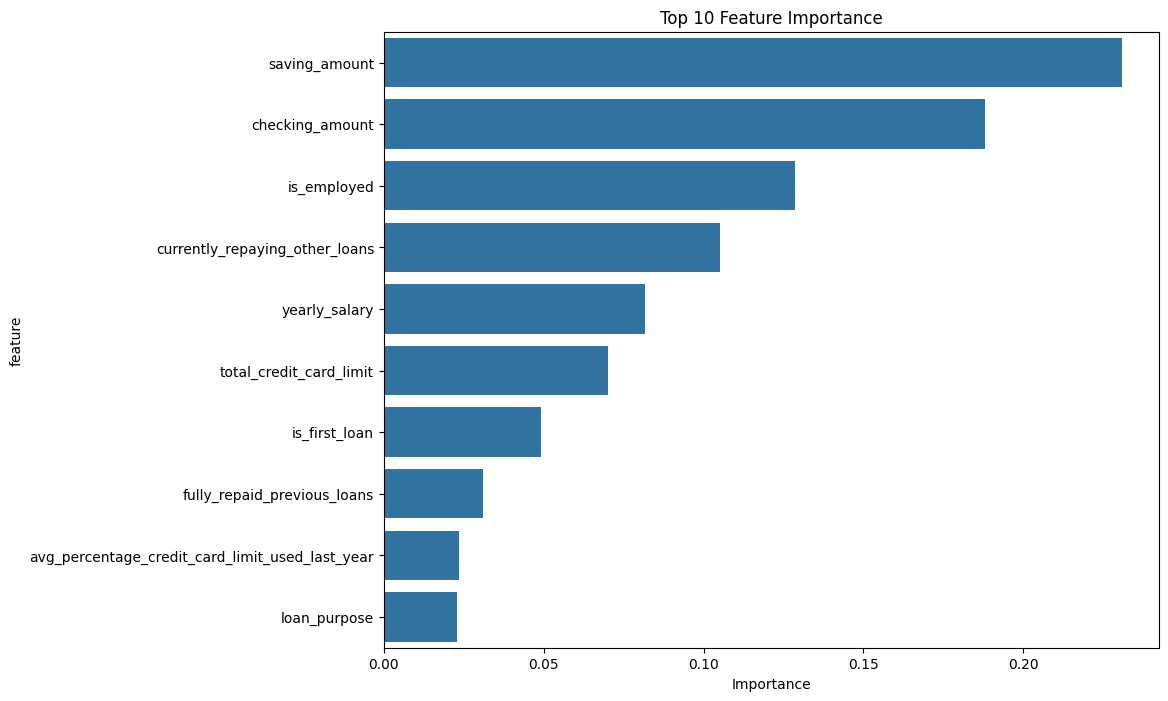


Top 10 Feature Importance:
                                           feature  importance
6                                    saving_amount    0.230919
7                                  checking_amount    0.188035
8                                      is_employed    0.128475
3                   currently_repaying_other_loans    0.105255
9                                    yearly_salary    0.081533
4                          total_credit_card_limit    0.070007
1                                    is_first_loan    0.049072
2                      fully_repaid_previous_loans    0.030892
5  avg_percentage_credit_card_limit_used_last_year    0.023614
0                                     loan_purpose    0.023018


In [52]:
feature_importance=model.feature_importances_
feature_names=X.columns
importance_df=pd.DataFrame({'feature':feature_names,'importance':feature_importance})
importance_df=importance_df.sort_values('importance',ascending=False)
plt.figure(figsize=(10,8))
sns.barplot(data=importance_df.head(10),x='importance',y='feature')
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')
plt.show()
print("\nTop 10 Feature Importance:")
print(importance_df.head(10))

#### Questions answers :
In my model, the top two features that really matter are saving amount and checking amount. Money in someone’s savings account shows how well they manage their finances, so it makes sense that more savings means they are more likely to repay a loan.

The feature is_employed doesn’t appear very important on its own, but it is closely tied to salary. People who aren’t employed have a salary of zero, and since salary is a strong predictor in the model, we can see that employment still matters indirectly. If someone has no income, they are much less likely to be approved for a loan. On the other hand, if they are employed, the amount of their salary helps determine their ability to repay — higher salary means more reliability.

Some other features that could be useful to include are marriage status, housing situation, and education level. Being married can help because a spouse might assist with repayments. Owning a house or the cost of rent matters too — if someone has a property, it could be sold to cover debts. Education level is important as well, because people with higher education often have better earning potential and may be more responsible in repaying loans.